When dealing with tabular data, it is advisable to use RandomForest for model selection. Why, because in the words of Fast.ai's Jeremy Howard, "it is very difficult to go wrong with an ensemble model such as random forests". Even with emergence of deep learning and neural networks, randomForests is an ol' trusty algorithm which can be implemented quickly and have uses for it's feature importance if you deem to build something better.

This notebook is my implementation of Chapter 7 from fast.ai's Course22. Lets go with the Titanic dataset, look at its features and build a model that iterates from OneR classifier all the way to decision trees and random forests.  

### Setup

In [136]:
from fastai.imports import *
np.set_printoptions(linewidth=100)

Here i setup the titanic dataset and use the given test & train split to get the corresponding data. I use the DataFrame.mode() function to find the most common terms across features

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


Before moving forward, lets look at a sample of the dataset. "Sex","Embarked" are categorical features whereas "Age","SibSp","Parch" and "Fare are continuous. For the purpose of this notebook, we ignore "Name", "PassengerId", "Ticket" and "Cabin". Oh! Also, the dependent variable here is "Survived" :)

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here I do some data processing, note that decision trees and random forest models do not need much preprocessing, however I do take an exponential of the Fare and convert values in "Sex" (for example: female, male to 0,1) and "Embarked" columns to categorical variables.

In [8]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace = True)
    df['LogFare'] = np.log1p(df.Fare)
    df['Sex'] = pd.Categorical(df.Sex)
    df['Embarked'] = pd.Categorical(df.Embarked)

proc_data(df)
proc_data(tst_df)

Note that "Pclass" isn't considered as categorical here because it is ordinal in nature and we need the model to see it that way.

In [18]:
dep = 'Survived'
cat = ['Sex','Embarked']
cont = ['Pclass','Age','LogFare','SibSp','Parch']

Females have a higher chance of survival compared to males and when comparing the distribution by 'Sex', it is seen that there isn't a heavy imabalance. Now the next step is to use predict survivability based on "Sex"

### Finding thresholds

[Text(0.5, 1.0, 'Distribution')]

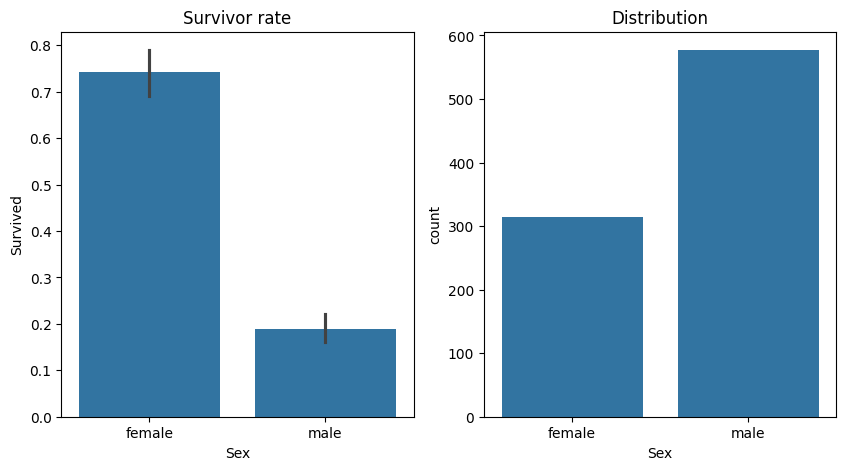

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = df, y= dep, x="Sex", ax=axs[0]).set(title="Survivor rate")
sns.countplot(data = df, x="Sex", ax=axs[1]).set(title="Distribution")

In [87]:
from sklearn.model_selection import train_test_split

#random.seed(400)
trn_df, val_df = train_test_split(df, test_size = 0.2)
trn_df[cat] = trn_df[cat].apply(lambda x: x.cat.codes)
val_df[cat] = val_df[cat].apply(lambda x: x.cat.codes)

In [88]:
def xs_y(df):
    xs = df[cont+cat].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)
    

A simple model to predict survivability if the 'Sex' is female:

In [45]:
preds = val_xs.Sex == 0

In [46]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.22905027932960895

Pretty good metric for one simple feature right? Now let's see how LogFare turns out as a predictor.

<Axes: xlabel='LogFare', ylabel='Density'>

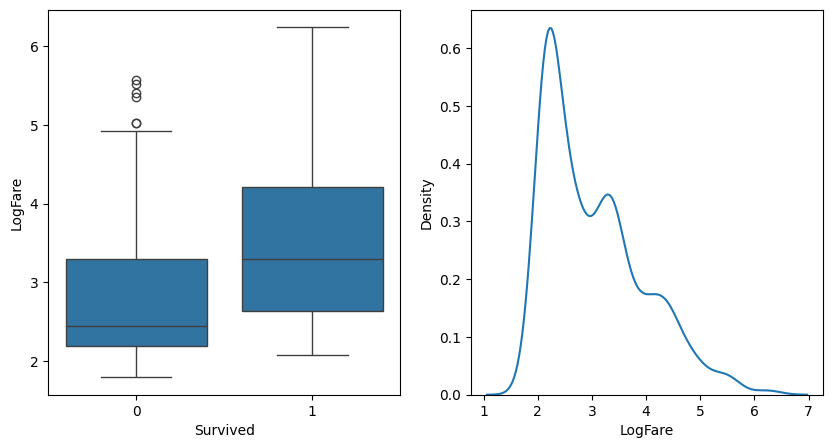

In [25]:
df_fare = trn_df[trn_df.LogFare > 0]
fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data = df_fare, x=dep, y= df_fare.LogFare, ax=axs[0])
sns.kdeplot(data = df_fare, x="LogFare", ax=axs[1])

The mean of Logfare for those who did not survive is somewhere around 2.5, hence I use 2.7 as a threshold to determine our predictions

In [47]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(preds, val_y)

0.3463687150837989

### Why do we need an impurity score?

There is a need for a better metric to find whether the threshold splits groups into distinct categories. We use an impurity score which takes the standard deviation of the corresponding dependent variable to verify whether the groups are separated properly. In our case, if a threshold results in more examples classified as 1s (Survived), then the impurity score would be less. 

Note that higher the score, greater the impurity and therefore a poor choice of threshold value.

In [89]:
def score(col, y, split):
    lhs = col <= split
    return (get_score(lhs, y) + get_score(~lhs, y))/len(y)

def get_score(side, y):
    tot = side.sum()
    if tot <= 1: return 0
    return y[side].std()*tot
    

In [90]:
score(trn_xs['Sex'], trn_y, 0.5)

0.41414800879325775

In [91]:
score(trn_xs['LogFare'], trn_y, 2.44379)

0.46221930969305186

"Sex" fares better than "LogFare" here, how about setting up a function to automatically determine a threshold that results in best split as per our impurity score? 

In [92]:
def best_split(df, y, col):
    unq = df[col].dropna().unique()
    scores = np.array([score(df[col], y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx], scores[idx]

best_split(trn_xs, trn_y, "LogFare")

(2.4390808375825834, 0.46127066301081265)

In [108]:
cols = cat+cont
{o: best_split(trn_xs, trn_y,o) for o in cols}

{'Sex': (0, 0.41414800879325775),
 'Embarked': (0, 0.48014791444506205),
 'Pclass': (2, 0.4575155591971377),
 'Age': (63.0, 0.4825003040505756),
 'LogFare': (2.4390808375825834, 0.46127066301081265),
 'SibSp': (4, 0.4808038181578302),
 'Parch': (0, 0.482323042902411)}

"Sex" would be the first predictor. Let's look at the next set of predictors for our model, by removing "Sex" form `cols`

In [111]:
cols.remove('Sex')
ismale = trn_df.Sex==1
males, females = trn_df[ismale],trn_df[~ismale]

{o: best_split(males, trn_y[ismale], o) for o in cols}

{'Embarked': (0, 0.39166879347494743),
 'Pclass': (1, 0.3843651127396164),
 'Age': (9.0, 0.38841912794090866),
 'LogFare': (2.7788192719904172, 0.38264146195354404),
 'SibSp': (4, 0.3934505108118341),
 'Parch': (0, 0.3945603968976307)}

In [112]:
{o: best_split(females, trn_y[~ismale], o) for o in cols}

{'Embarked': (0, 0.43435165774358364),
 'Pclass': (2, 0.33558335599293315),
 'Age': (50.0, 0.4266695340546771),
 'LogFare': (4.256321678298823, 0.4026338739250313),
 'SibSp': (2, 0.421445832851724),
 'Parch': (3, 0.4380590153581859)}

This method is similar to a decision tree, which finds the best value to split features and create a tree based model for prediction

## Decision Tree

In [113]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes = 4).fit(trn_xs, trn_y)

In [114]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

The decision tree determines split similar to our findings above, starting with "Sex" and then "Pclass" as the second split.

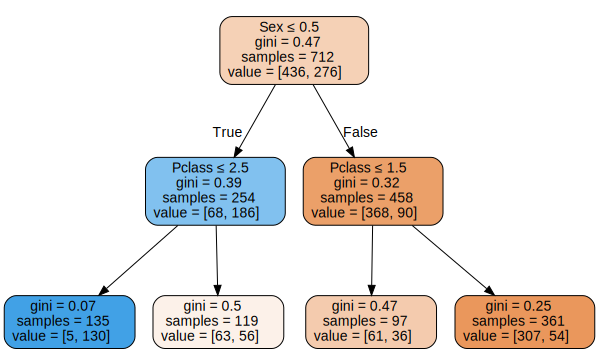

In [115]:
draw_tree(m, trn_xs)

Gini scores are similar to impurity scores, and they are calculated as shown below

In [117]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

gini(df.Sex=='female'),gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [119]:
mean_absolute_error(val_y,m.predict(val_xs))

0.21787709497206703

The error metric is as good as our simple one feature predictor shown earlier, but that could also be because we are dealing with a limited dataset. Lets change our model by requiring each leaf node to contain atleast 50 data points and look at how the tree is modeled.

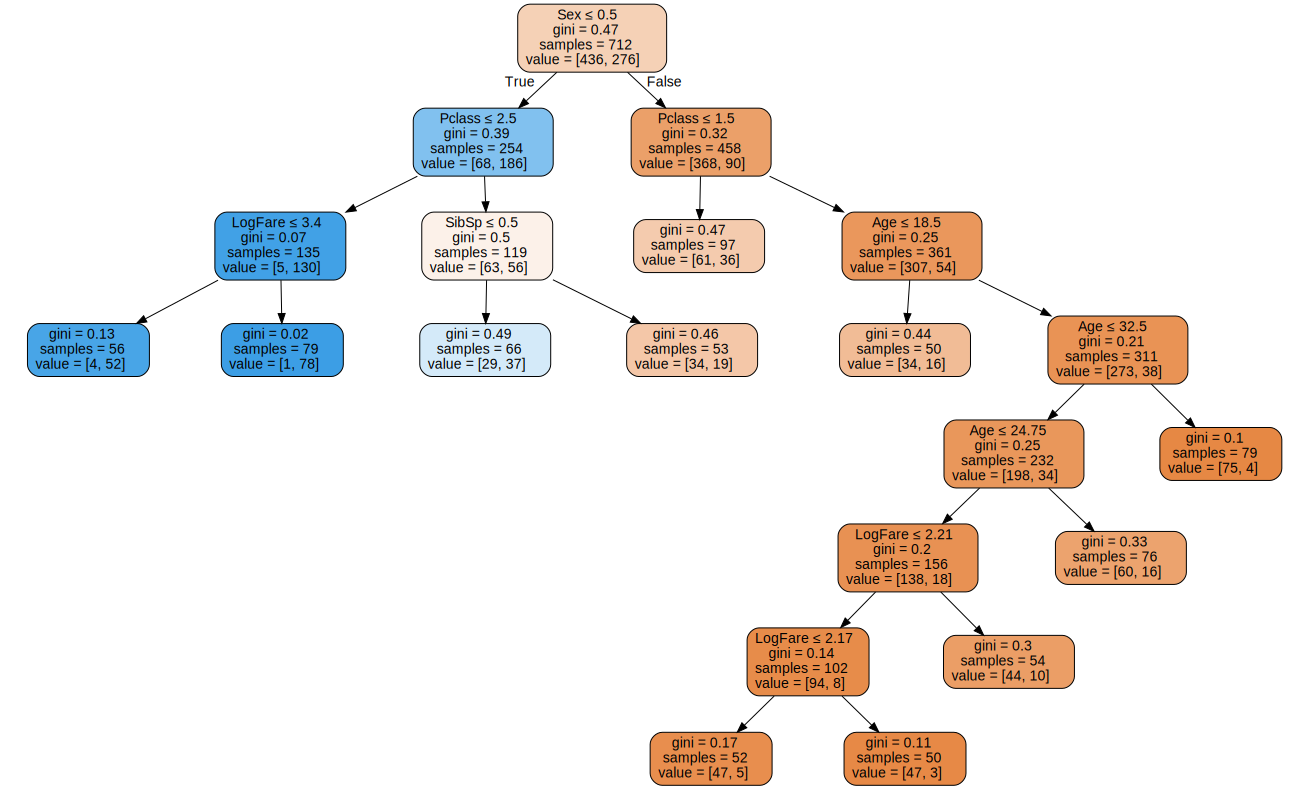

In [120]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [121]:
mean_absolute_error(val_y, m.predict(val_xs))

0.1787709497206704

## Random Forest

This is a better model. Now remember when Goku from DragonBall says "you haven't seen my final form yet", what happens next is the machine learning version of it. In a decision tree, the threshold value of the split is determined by the portion of data or the training dataset exposed to the model. One way to improve upon this is to select indexes at random for training and build multiple trees, their average predict probability should ideally be a better model than a single decision tree.  This is the final form, called a Random Forest model.

In [131]:
def get_tree(prop=0.7):
    n = len(trn_y)
    idx = np.random.choice(n, int(n*prop), replace = False)
    return DecisionTreeClassifier(min_samples_leaf = 5).fit(trn_xs.iloc[idx], trn_y.iloc[idx])

trees = [get_tree() for t in range(100)]

all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(avg_probs, val_y)

0.19145251396648041

Again, it is entirely possible that we may not see a huge increase in accuracy because of the limited data we are dealing with. However, the takeaway here is that this is exactly how scikit-learn's RandomForest model works

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf =5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18435754189944134

Bummer, I do not want to talk anymore about performance. So let me show you RandomForest's `feature_importances_` that shows the model's understanding of main features in a dataset. As per Jeremy Howard, this is tougher to mess up so can be used as a default method to find feature importance as compared to others.

<Axes: ylabel='cols'>

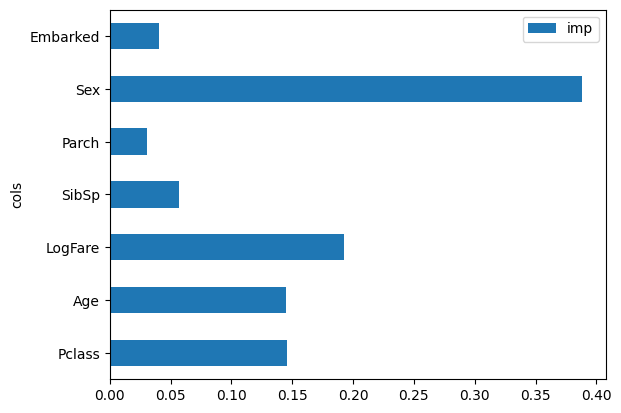

In [133]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols','imp','barh')

In [135]:
tst_df[cat] = tst_df[cat].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(rf.predict(tst_xs), 'tree')


Fin!